# GNN demo

## Prepare data

In [2]:
import networkx as nx
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

In [2]:
# load graph from networkx library
G = nx.karate_club_graph()

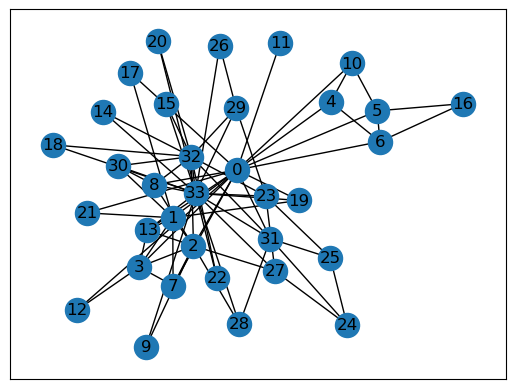

In [3]:
nx.draw_networkx(G)

In [4]:
# retrieve the labels for each node
labels = np.asarray([G.nodes[i]['club'] != 'Mr. Hi' for i in G.nodes]).astype(np.int64)

In [5]:
# create edge index from
adj = nx.to_scipy_sparse_array(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

In [6]:
edge_index.shape

torch.Size([2, 156])

In [7]:
# using degree as embedding
embeddings = np.array(list(dict(G.degree()).values()))

In [8]:
# normalizing degree values
scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1, 1))

## Custom dataset

In [3]:
import torch
import pandas as pd
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split
import torch_geometric.transforms as T

In [10]:
# custom dataset
class KarateDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(KarateDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)

        data.num_nodes = G.number_of_nodes()

        # embedding
        data.x = torch.from_numpy(embeddings).type(torch.float32)

        # labels
        y = torch.from_numpy(labels).type(torch.long)
        data.y = y.clone().detach()

        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())),
                                                            pd.Series(labels),
                                                            test_size=0.30,
                                                            random_state=42)

        n_nodes = G.number_of_nodes()

        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [11]:
dataset = KarateDataset()
data = dataset[0]

## Alternative for the last two sections

In [12]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid('data', 'cora')
data = dataset.data

In [13]:
data.num_classes = len(data.y.unique())
data.num_features

1433

## My data from scratch

In [17]:
num_nodes = 5
feature_vector_len = 8

x = np.random.random((num_nodes, feature_vector_len))
adj_matrix = np.random.randint(0, 2, (num_nodes, num_nodes))
adj_matrix = np.triu(adj_matrix, k=1).T + np.triu(adj_matrix, k=1) + np.diag(adj_matrix.diagonal())
similarities = torch.from_numpy(np.random.rand(num_nodes, num_nodes) * 2 - 1).to(dtype=torch.float32)

G = nx.from_numpy_matrix(adj_matrix)
for node in G.nodes:
    G.nodes[node]['x'] = x[node]

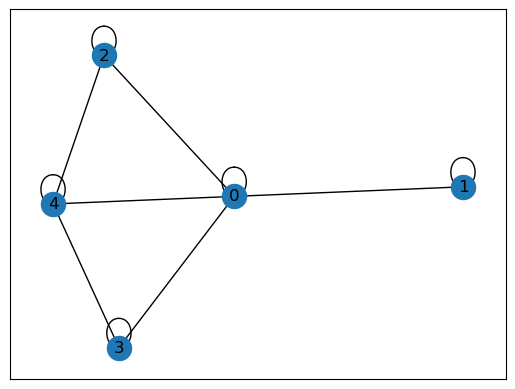

In [18]:
nx.draw_networkx(G)

In [19]:
edge_index = torch.from_numpy(np.array(G.edges, dtype=np.int64).T)
edge_index

tensor([[0, 0, 0, 0, 0, 1, 2, 2, 3, 3, 4],
        [0, 1, 2, 3, 4, 1, 2, 4, 3, 4, 4]])

In [20]:
# custom dataset
class MyDataset(InMemoryDataset):
    def __init__(self, edge_index, num_nodes, embeddings, y, transform=None):
        super(MyDataset, self).__init__('.', transform, None, None)
        data = Data(edge_index=edge_index)
        data.num_nodes = num_nodes
        # embedding
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        self.data, self.slices = self.collate([data])
        # y - similarities
        data.y = y

In [21]:
dataset = MyDataset(edge_index=edge_index, num_nodes=G.number_of_nodes(), embeddings=x, y=similarities)
data = dataset[0]

## Model

In [22]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [23]:
class Net(torch.nn.Module):
    def __init__(self, out_features):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 16)
        self.conv2 = GCNConv(16, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        return x

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = Net(out_features=10).to(device)
x = model(data)

## Training

In [25]:
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

100%|██████████| 499/499 [00:01<00:00, 390.16it/s]


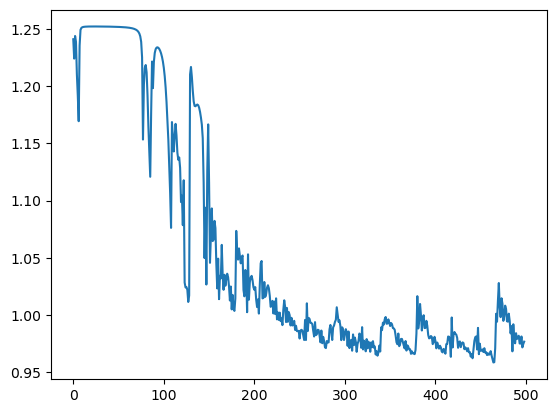

In [26]:
torch.manual_seed(42)

optimizer_name = "Adam"
lr = 1e-1
optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
epochs = 500


def similarity_loss(outputs, data, p=1):
    edge_index = data.y, data.edge_index
    edges = round(edge_index.shape[1] * p)
    indexes = sorted(random.sample(range(edge_index.shape[1]), edges))
    edges = edge_index[:, indexes]
    edges_similarities = similarities[edges[0], edges[1]]
    cosines = nn.CosineSimilarity()(outputs[edges[0]], outputs[edges[1]])
    MSE = nn.MSELoss()(cosines, edges_similarities)
    return MSE


def train(data):
    model.train()
    optimizer.zero_grad()
    outputs = model(data)
    loss = similarity_loss(outputs, data)
    loss.backward()
    optimizer.step()
    return loss

losses = []
for epoch in tqdm(range(1, epochs)):
    loss = train(data)
    losses.append(loss.item())

plt.plot(list(range(len(losses))), losses)
plt.show()

In [27]:
losses

[1.241124153137207,
 1.224204659461975,
 1.2439783811569214,
 1.2388460636138916,
 1.2101242542266846,
 1.1919077634811401,
 1.1694668531417847,
 1.2356642484664917,
 1.2493408918380737,
 1.251054286956787,
 1.2516101598739624,
 1.251868486404419,
 1.2520121335983276,
 1.2521010637283325,
 1.252159595489502,
 1.2521998882293701,
 1.2522286176681519,
 1.2522491216659546,
 1.2522636651992798,
 1.2522742748260498,
 1.2522810697555542,
 1.2522855997085571,
 1.252287745475769,
 1.2522882223129272,
 1.2522873878479004,
 1.252285122871399,
 1.2522817850112915,
 1.2522774934768677,
 1.252272129058838,
 1.2522659301757812,
 1.2522587776184082,
 1.2522510290145874,
 1.2522422075271606,
 1.2522327899932861,
 1.2522224187850952,
 1.2522114515304565,
 1.2521995306015015,
 1.25218665599823,
 1.2521729469299316,
 1.252158284187317,
 1.2521424293518066,
 1.2521257400512695,
 1.2521077394485474,
 1.2520884275436401,
 1.2520676851272583,
 1.252045750617981,
 1.2520219087600708,
 1.251996397972107,
 1.25